## Project Introduction:
`Advanced Surveillance System` is a system that tracks whereabout of a targeted individual or individuals in a building. The system will use pre-trained multi-task cascaded convolutional networks to extract faces from surveillance cameras at a predetermined interval. The extracted faces will be preprocessed and send to a trained FaceNet model to see if the targeted individual is seen. If yes, the system will log into database the individual’s name, location and time it sees the individual. 

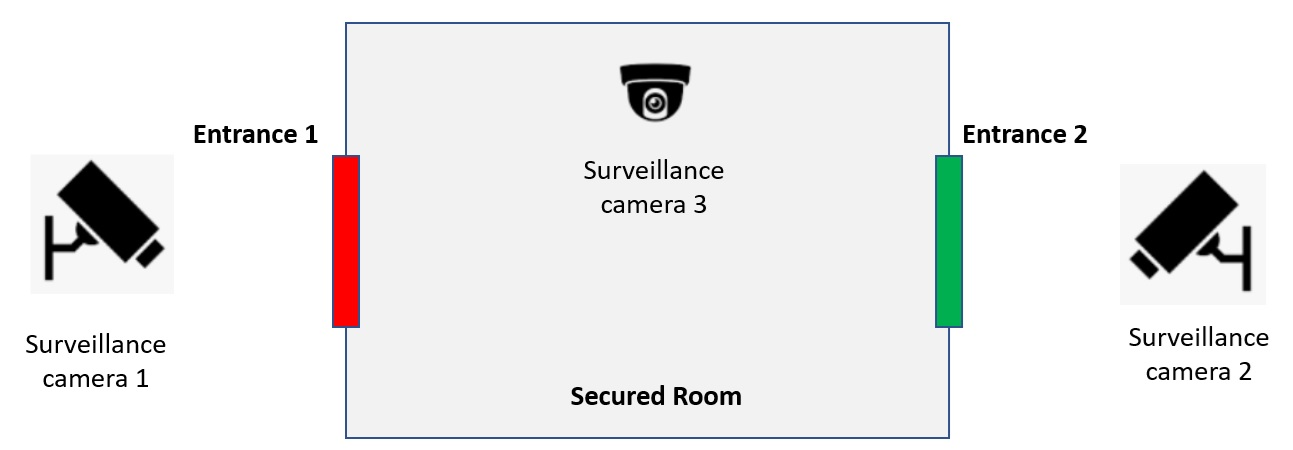

In [2]:
from PIL import Image
INTRO_PIC = ".\\input\\supporting\\intro.jpg"
intro_img = Image.open(INTRO_PIC)
display(intro_img)

### This was my goal:
Both cameras are actually simulated by running `camera.py` with proper arguments. Facial images are extracted at camera end (`camera.py`) and embeddings of them are calculated using pre-trained FaceNet model. It is then serialized and send to Kafka server. A process (`processor.py`) will run in the background on a server hosting the web applications. It will read messages from Kafka server and check distances between embeddings. If distance is less than predetermined threshold, the two embeddings are considered of the same individual. The system will record the finding into databse.

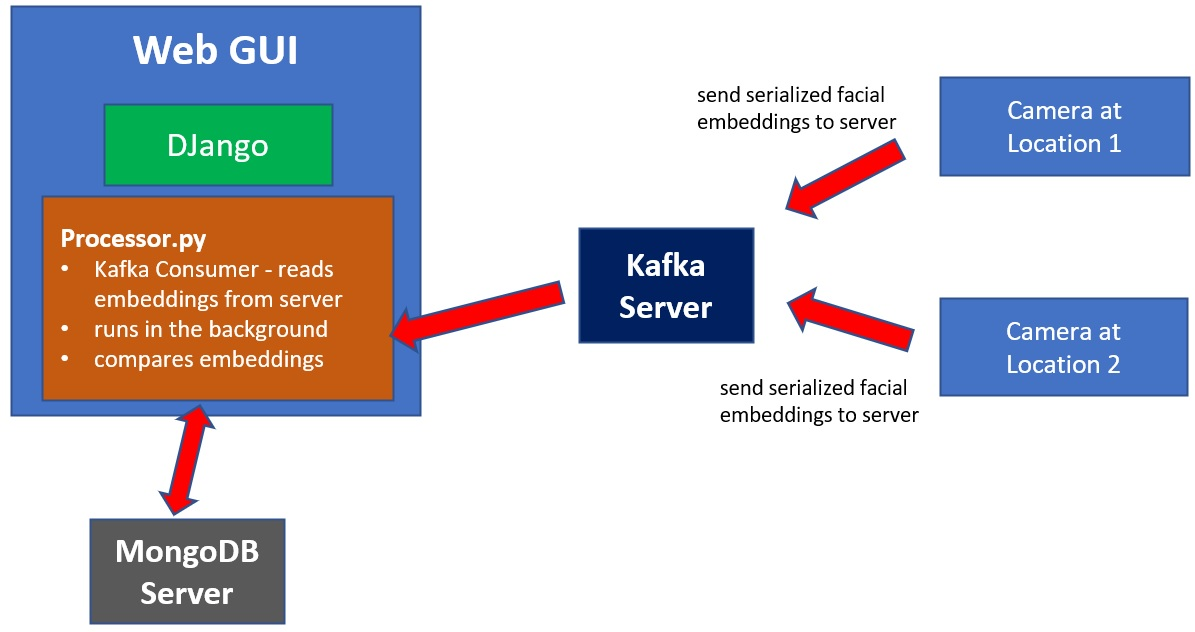

In [3]:
GOAL_PIC = ".\\input\\supporting\\goal.jpg"
goal_img = Image.open(GOAL_PIC)
display(goal_img)

### Final:
I was struggling to run `processor.py` as a separate thread. I have to compromised my deliverable to what is shown below. Basically, there will not be a process running background with the Django applications. But, other than that, the final deliverable is very similar to the original goal. 

Ideally, both cameras should be in a separate docker to simulate client nodes. For demo purposes, I have decided to put them together with the other pieces. Not creating additional container saves disk space and time.

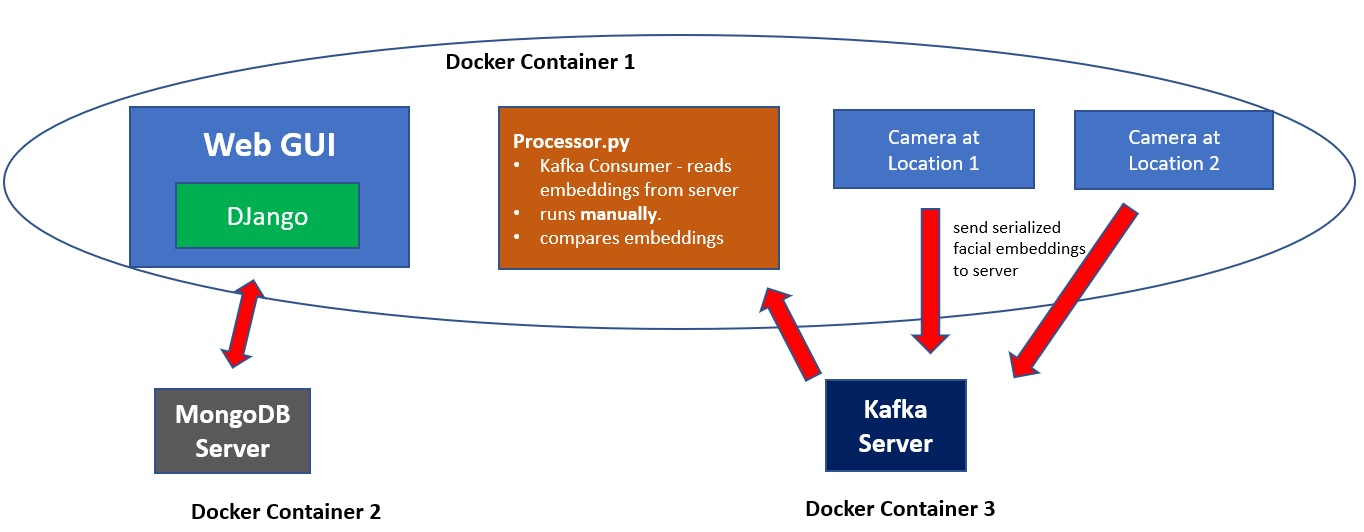

In [4]:
FINAL_PIC = ".\\input\\supporting\\final.jpg"
final_img = Image.open(FINAL_PIC)
display(final_img)

### Some demos:

In [5]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import euclidean_distances
from keras.models import load_model
import os
import cv2
from cv2 import CascadeClassifier
import tensorflow as tf

from IPython.display import display # to display images
# load the model
GLOBAL_facenet_model = load_model('.\\pre-trained\\facenet_keras.h5', compile=False)
GLOBAL_face_finder = CascadeClassifier('.\\pre-trained\\haarcascade_frontalface_default.xml')

Using TensorFlow backend.


In [6]:
# Resize array of face.
def resize_array(input_img_array, required_size=(160, 160)):
    input_img = Image.fromarray(input_img_array)
    input_img = input_img.resize(required_size)
    resized_face_array = asarray(input_img)
    return resized_face_array


# get the face embedding from input array.
def get_embedding(input_img_array):
    face_array = input_img_array.astype('float32')           
    mean, std = face_array.mean(), face_array.std()     # scale pixel values
    face_array = (face_array - mean) / std              # standardize pixel values across channels (global)
    samples = expand_dims(face_array, axis=0)           # transform face into one sample
    yhat = GLOBAL_facenet_model.predict(samples)        # make prediction to get embedding
    in_encoder = Normalizer(norm='l2')
    yhat = in_encoder.transform(yhat)
    return yhat[0]

# Compare two images and return distance. Distance can be used to compare to threshold.
def compare(img1,img2):
    input_img = Image.open(img1)
    input_img = input_img.convert('RGB')
    input_img = asarray(input_img)
    input_img2 = Image.open(img2)
    input_img2 = input_img2.convert('RGB')
    input_img2 = asarray(input_img2)
    bboxes = GLOBAL_face_finder.detectMultiScale(input_img,1.10,20)
    for box in bboxes:
        x1, y1, width, height = box
        x2, y2 = x1 + width, y1 + height
        face = input_img[y1:y2, x1:x2]
        face = resize_array(face)
        f = Image.fromarray(face)
        display(f)
    embedding1 = get_embedding(face)
    bboxes = GLOBAL_face_finder.detectMultiScale(input_img2,1.10,20)
    for box in bboxes:
        x1, y1, width, height = box
        x2, y2 = x1 + width, y1 + height
        face = input_img2[y1:y2, x1:x2]
        face = resize_array(face)
        f = Image.fromarray(face)
        display(f)
    embedding2 = get_embedding(face)
    result = euclidean_distances([embedding1],[embedding2])
    return result[0][0]


### Sample comparison:
Looking at the comparisons below, we can safely say that, the distance of two embeddings from same individual is less than 1.0.

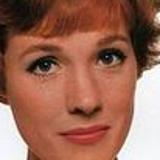

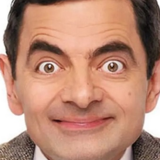

Accuracy: result=1.44537


In [7]:
img1 = ".\\input\\targets\\julia_andrews1.jpg"
img2 = ".\\input\\targets\\rowan_atkinson1.jpg"
print('Accuracy: result=%.5f' % (compare(img1,img2)))

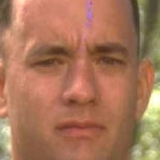

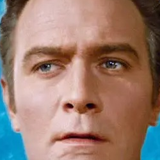

Accuracy: result=1.37204


In [8]:
img1 = ".\\input\\targets\\tom_hanks6.jpg"
img2 = ".\\input\\targets\\christopher_plummer1.jpg"
print('Accuracy: result=%.5f' % (compare(img1,img2)))

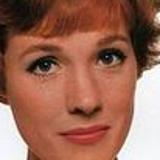

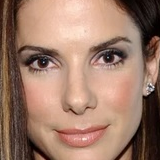

Accuracy: result=1.44994


In [9]:
img1 = ".\\input\\targets\\julia_andrews1.jpg"
img2 = ".\\input\\targets\\sandra_bullock3.jpg"
print('Accuracy: result=%.5f' % (compare(img1,img2)))

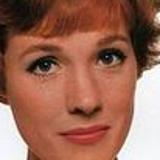

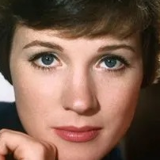

Accuracy: result=0.62751


In [10]:
img1 = ".\\input\\targets\\julia_andrews1.jpg"
img2 = ".\\input\\targets\\julia_andrews2.jpg"
print('Accuracy: result=%.5f' % (compare(img1,img2)))

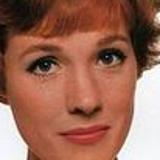

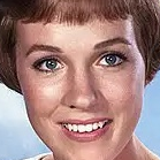

Accuracy: result=0.66745


In [11]:
img1 = ".\\input\\targets\\julia_andrews1.jpg"
img2 = ".\\input\\targets\\julia_andrews3.jpg"
print('Accuracy: result=%.5f' % (compare(img1,img2)))


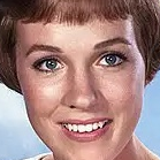

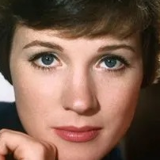

Accuracy: result=0.64143


In [12]:
img1 = ".\\input\\targets\\julia_andrews3.jpg"
img2 = ".\\input\\targets\\julia_andrews2.jpg"
print('Accuracy: result=%.5f' % (compare(img1,img2)))

# Instructions:

### Instructions for setting up MongoDB server:

1) docker pull mongo:latest

2) docker run --name mongodb -d -p 27017:27017 mongo

3) Create host directories:
   - mkdir C:\temp\nosql\mongo
   - mkdir C:\temp\nosql\mongo\import
   - mkdir C:\temp\nosql\mongo\data
   
4) docker run --name mongodb -d -p 27017:27017 -v C:/temp/nosql/mongo/data:/data/db -v C:/temp/nosql/mongo/import:/import mongo



### Instructions for setting up Kafka server:

1) Download `docker-compose.yml` from GitHub ----------MY LINK  HERE------------------ 

2) docker-compose up -d 

3) Command to test connections (in Windows):
   - test-netconnection localhost -port 29092
   - test-netconnection localhost -port 22181


### Accessing the Web GUI


See `Readme.txt`.


### References:

1) https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

2) https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/

3) F. Schroff, D. Kalenichenko, J. Philbin, FaceNet: A Unified Embedding for Face Recognition and Clustering, arXiv: 1503.03832v3, 2015.